# Calculate the Oceanic Niño Index (ONI) from NOAA OISST satellite data

## Nino 3.4 and the ONI Index

El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

Source: https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/

![image.png](attachment:image.png)

_Niño regions of the equatorial Pacific Ocean. The Niño 3.4 region is used when calculating the Oceanic Niño Index.  Image Credit: NOAA._

### In this notebook, we:


- Load NOAA OISST SST anomaly satellite data from 1982 to 2019


- Average the SST anomalies over the Nino 3.4 region: 5°S-5°N and 190°E to 240°E (Note 240°E = 120°W) and save this to a netcdf file called 'noaa_oisst_v2_sst_anom_nino34.nc'


- Saves the SST anomaly averaged over the Nino 3.4 region to a netcdf file called 'noaa_oisst_v2_sst_anom_nino34.nc'


- Calculate the ONI index, i.e., the 3-month running mean of the Nino 3.4 SST anomalies


- Apply the above definition of El Niño (La Niña) to determine, for each day, the ENSO phase (i.e. El Nino, La Nina or neutral)


- Save the ONI index and event timeseries to a netcdf file called 'noaa_oisst_v2_nino34_index.nc'

In [104]:
# Load required modules.
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [2]:
# Directory where NOAA OISST files are saved (on the NCI supercomputer Raijin in Alex Sen Gupta's folder).
path = '/g/data1/ua8/NOAA_OISST/AVHRR/v2-0_modified/'

# Path to save the modified data ((on the NCI supercomputer Raijin in Annette's folder).
save_path = '/g/data/e14/as3189/MHW/data/'

# List of file names to import. While we only want data from 1982 onwards, we need the last few months 
# of 1981 to calculate the Oceanic Nino Index (i.e. the 3-month running mean). 
files = ['{}oisst_avhrr_v2_{}.nc'.format(path, year) for year in range(1981, 2019 + 1)]

In [3]:
# Open all files as an xarray dataset.
data = xr.open_mfdataset(files, combine='by_coords')

data = data.isel(zlev=0) # Select the surface of the ocean (there aren't any other depths anyway).

# Delete unnecessary variables and coordinates.
data = data.drop('ice')
data = data.drop('err')
data = data.drop('zlev')

print(data)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 13857)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2019-08-09
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
    anom     (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.7.1 (http://mpimet...
    title:                Daily-OI-V2, final, Data (Ship, Buoy, AVHRR, GSFC-ice)
    History:              Version 2.0
    creation_date:        2011-05-04
    Contact:              Dick Reynolds, email: Richard.W.Reynolds@noaa.gov &...
    CDO:                  Climate Data Operators version 1.7.1 (http://mpimet...
    summary:              Original files downloaded from ftp://eclipse.ncdc.n...

### Average the SST anomalies over the Nino 3.4 region (5°S-5°N and 190°E-120°W).

In [4]:
# Note that the longitudes go from 0-360°E, so to convert °W to °E you minus the western lat from 360 
# (i.e. 240°E=360-120°W).
sst_anom_nino34 = data.anom.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(['lon', 'lat'])

### Calculate the monthly mean SST anomalies as an xarray dataset.

In [5]:
ds = xr.Dataset() # Creates an empty xarray dataset.

# Add data array called nino34 (this will also add the time coordinate)
# MonthBegin 	'MS' 	calendar month begin
ds['nino34'] = sst_anom_nino34.resample(time='MS').mean()

# Copy details from oringial data files (like data version, etc).
ds.attrs = data.attrs
ds.nino34.attrs = data.anom.attrs

# It's always good to add some metadata so that you know what the file contains when you open it!
ds.nino34.attrs['long_name'] = 'Monthly SST anomalies averaged over the Nino 3.4 region'

# Preview what the file will look like.
print(ds.nino34)

# Save to a netcdf file (may take quite a while to calculate and save).
ds.to_netcdf(save_path + 'sst_anom_nino34.nc')

<xarray.DataArray 'nino34' (time: 456)>
dask.array<stack, shape=(456,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2019-08-01
Attributes:
    long_name:  Monthly SST anomalies averaged over the Nino 3.4 region


RuntimeError: NetCDF: HDF error

## Calculate the Oceanic Nino Index (ONI).

In [82]:
ds = xr.open_dataset(save_path + 'sst_anom_nino34.nc')

# Calculate the three month running mean.
oni = ds.nino34.rolling(time=3).mean()

In [83]:
# Remove the last few months of 1981 from ONI (we only want values from 1982 onwards.)
oni = oni.isel(time=slice(4, len(oni)))

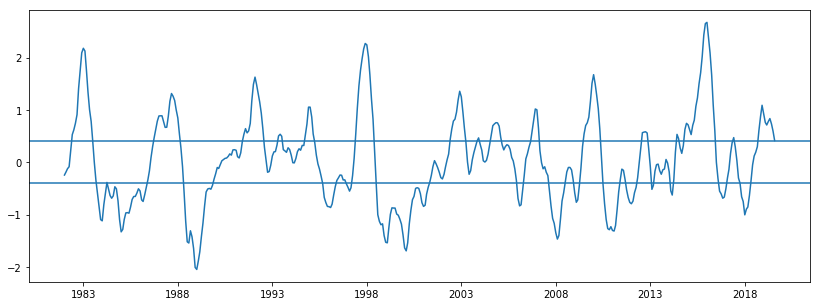

In [84]:
# Quick plot to see how it looks (basically a smoothed version of nino34).
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(oni.time, oni)
ax.axhline(0.4)
ax.axhline(-0.4)
# ax.set_xticks(np.arange(len(oni.time)))
# oni

### Label ENSO events as 'nino', 'nina' or 'none' based on the ONI and nino threshold. 

- El Nino events: ONI values greater than or equal to 0.5°C
- La Nina events: ONI values less than or equal to -0.5°C
- Neutral ('none'): ONI values between -0.5°C and 0.5°C

In [91]:
nino_thresh = 0.5 # The SST [°C] threshold for definiting events.

# The nino array is just a time series of months labeled either 'none', 'nino' or 'nina'.
nino = xr.full_like(oni, 'none', dtype='U4') # Start by labelling all events as neutral ('none').
nino[oni > nino_thresh] = 'nino' # If the SST anomaly is greater than or equal to 0.5°C: label it 'nino'.
nino[oni < -nino_thresh] = 'nina' # If the SST anomaly is less than or equal to -0.5°C: label it 'nina'.

# Printing the sum of El Nino and La Nina months.
print('Number of El Nino months: {}'.format((nino == 'nino').sum().item()))
print('Number of La Nina months: {}'.format((nino == 'nina').sum().item()))
print('Number of Neutral months: {}'.format((nino == 'none').sum().item()))

Number of El Nino months: 128
Number of La Nina months: 130
Number of Neutral months: 194


In [92]:
months = 5
i = 0 # Counter.
while i < len(nino):
    # Check if month 'i' is tagged as 'nino' or 'nina', otherwise just skip to the next month (i + 1).
    if nino[i] != 'none':
        # Find the next day index that is tagged as 'none'. 
        # Note that nino[i:] is the nino array neglecting all the days before 'i' and np.argwhere will tell us 
        # where all the indexes of 'none' are, but we are only interested in the very next 'none' (i.e. [0][0]).
        try:
            end = np.argwhere([n != nino[i] for n in nino[i:]])[0][0]
        except:
            
            if all(nino[i:] == nino[i]):
                print(nino[i])
                end = len(nino)
                
        # So, 'end' number of days after day 'i' is when the next non-event occurs 
        # (i.e. the end of the nina or nino event).
        # This means 'end' is the duration of the event. 
        # If the event duration is shorter than the days threshold, rename all these labels as 'none'.
        if end < months:
            nino[i:i + end] = ['none']*(end) 

            
        # Jump up the counter by all the days we just went through.
        i += end + 1
    else:
        i += 1

# Printing the sum of El Nino and La Nina months.
print('Number of El Nino months: {}'.format((nino == 'nino').sum().item()))
print('Number of La Nina months: {}'.format((nino == 'nina').sum().item()))
print('Number of Neutral months: {}'.format((nino == 'none').sum().item()))

Number of El Nino months: 121
Number of La Nina months: 114
Number of Neutral months: 217


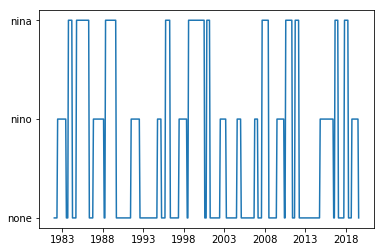

In [93]:
plt.plot(oni.time,nino)

In [94]:
oni

<xarray.DataArray (time: 452)>
array([-0.24235521, -0.18127882, -0.12113389, -0.08337604,  0.20860331,
        0.53050834,  0.6210241 ,  0.74695075,  0.91309994,  1.4103801 ,
        1.7463583 ,  2.0946414 ,  2.1807957 ,  2.1281602 ,  1.7729454 ,
        1.3402184 ,  1.0069008 ,  0.7829385 ,  0.412273  , -0.00007045,
       -0.3426705 , -0.59199464, -0.84101474, -1.0940268 , -1.1179909 ,
       -0.8080535 , -0.60165524, -0.3839168 , -0.5084078 , -0.6339644 ,
       -0.6855251 , -0.64037746, -0.4662546 , -0.5058896 , -0.73484445,
       -1.092627  , -1.3281202 , -1.2809777 , -1.093419  , -0.9662403 ,
       -0.9605202 , -0.9712681 , -0.8552729 , -0.7090105 , -0.6518848 ,
       -0.6513909 , -0.58645105, -0.5045563 , -0.54638344, -0.7177863 ,
       -0.74758744, -0.6197301 , -0.4835423 , -0.33549142, -0.16321522,
        0.09242034,  0.30045348,  0.47363722,  0.63267565,  0.78847235,
        0.8870529 ,  0.89031327,  0.8900451 ,  0.7800865 ,  0.6688644 ,
        0.6716449 ,  0.8805566 ,  1.1682512 ,  1.3161366 ,  1.2653514 ,
        1.182584  ,  1.0015931 ,  0.84952295,  0.5413962 ,  0.27810803,
       -0.08271243, -0.5697814 , -1.1233597 , -1.5183791 , -1.5419964 ,
       -1.3077055 , -1.4210005 , -1.647609  , -2.008334  , -2.046832  ,
       -1.8805015 , -1.7090682 , -1.4167383 , -1.1609855 , -0.83568496,
       -0.5665306 , -0.50874954, -0.49766183, -0.5130762 , -0.4395849 ,
       -0.32167202, -0.21847054, -0.09788587, -0.11668985, -0.04104545,
        0.02996415,  0.05399562,  0.07614835,  0.08284079,  0.11445972,
        0.16196063,  0.138295  ,  0.23834524,  0.2419163 ,  0.23176299,
        0.10828109,  0.08456403,  0.18203387,  0.39979172,  0.53623766,
        0.6448374 ,  0.5634339 ,  0.6021346 ,  0.74461883,  1.1755049 ,
        1.4894545 ,  1.629525  ,  1.4938077 ,  1.3228087 ,  1.1559954 ,
        0.94118154,  0.6451522 ,  0.29009935,  0.05143857, -0.18949258,
       -0.17481911, -0.05466998,  0.12271019,  0.20116556,  0.20583588,
        0.33099923,  0.5055306 ,  0.5372716 ,  0.49934113,  0.24330197,
        0.21937475,  0.1920924 ,  0.2793815 ,  0.24478942,  0.13760686,
       -0.00705829, -0.0097445 ,  0.07526009,  0.20455614,  0.25995383,
        0.2323755 ,  0.32425517,  0.3222087 ,  0.5184978 ,  0.7339319 ,
        1.0556358 ,  1.0559824 ,  0.86649656,  0.5436493 ,  0.37546214,
        0.1397147 , -0.03002822, -0.12847799, -0.26136082, -0.40560687,
       -0.6700424 , -0.7686373 , -0.84214425, -0.84692615, -0.8629056 ,
       -0.7978524 , -0.62064797, -0.46446782, -0.34478885, -0.29614535,
       -0.24159543, -0.24642259, -0.33594164, -0.33394158, -0.40860018,
       -0.47542518, -0.549462  , -0.48477435, -0.24899936,  0.08035593,
        0.5436126 ,  1.0300578 ,  1.4605224 ,  1.7609814 ,  1.9760804 ,
        2.1685815 ,  2.2727613 ,  2.2465925 ,  2.0188382 ,  1.6760973 ,
        1.2074755 ,  0.8234922 ,  0.18823147, -0.39995074, -1.0009899 ,
       -1.1279857 , -1.192559  , -1.1744318 , -1.3991979 , -1.5283575 ,
       -1.537876  , -1.2650907 , -0.99384165, -0.8692663 , -0.8730766 ,
       -0.8736404 , -0.9872923 , -1.0108069 , -1.0845089 , -1.1796823 ,
       -1.3828537 , -1.6335958 , -1.6917655 , -1.5369062 , -1.1733651 ,
       -0.9195312 , -0.71334696, -0.6504251 , -0.4969518 , -0.4844055 ,
       -0.4972872 , -0.59757495, -0.7703921 , -0.8417887 , -0.81849265,
       -0.6078657 , -0.47612557, -0.3806481 , -0.24792552, -0.08306879,
        0.03250202, -0.02816805, -0.10044307, -0.18938613, -0.29087204,
       -0.31617284, -0.2288826 , -0.09045599,  0.04686133,  0.1587258 ,
        0.44394442,  0.63751316,  0.789102  ,  0.8265501 ,  0.9619691 ,
        1.1952391 ,  1.3594337 ,  1.2549009 ,  0.9601971 ,  0.66302955,
        0.37595648,  0.0064832 , -0.22754985, -0.15911967,  0.0478822 ,
        0.1864722 ,  0.29821467,  0.40576288,  0.46782467,  0.34467468,
        0.23273599,  0.03003752,  0.00630179,  0.03746011,  0.15463448,
        0.33889967,  0.51752436,  0.7012477 ,  0.7339468 ,  0.75924885,
        0

### Create dataset for ONI and Nino event timeseries.

In [10]:
do = xr.Dataset() # Creates an empty xarray dataset.

do['oni'] = oni # Add the data array and call it oni
do['nino'] = nino # Add the data array and call it nino
do.attrs = data.attrs
do.oni.attrs = data.anom.attrs

# It's always good to add some metadata so that you know what the file contains when you open it!
do.oni.attrs['long_name'] = 'Oceanic Nino Index (ONI)'
do.oni.attrs['description'] = 'Three month running mean of SST anomalies averaged over the Nino 3.4 region'
do.nino.attrs['long_name'] = 'ENSO events based on ONI values above or below 0.5 deg C' 

### Save the monthly ONI and Nino event timeseries to netcdf file and csv files.

Note that this may take quite a while to calculate and save.

In [11]:
# Save ONI and nino events to a netcdf file.
do.to_netcdf(save_path + 'oceanic_nino_index.nc') 

# Save ONI and nino events to a csv file.
dp = do.to_dataframe()
dp.to_csv(save_path + 'oceanic_nino_index.csv')

In [12]:
data.close()
ds.close()
do.close()

In [13]:
# # Remove the last few months of 1981 from nino34 (we only want values from 1982 onwards.)
# ds = ds.isel(time=slice(4, len(ds.nino34) - 1))

# # Save over previous SST netcdf file with the last few months of 1981 removed.
# ds.to_netcdf(save_path + 'sst_anom_nino34.nc')

In [102]:
do.time

<xarray.DataArray 'time' (time: 452)>
array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1982-03-01T00:00:00.000000000', ..., '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-08-01

In [132]:
soi = pd.read_csv('data/BoM_SOI.csv')
df = xr.Dataset({'soi': ('time', soi.soi.values)}, coords={'time': soi.time.values}) # Creates an empty xarray dataset.
df

<xarray.Dataset>
Dimensions:  (time: 454)
Coordinates:
  * time     (time) object '1982-01-01' '1982-02-01' ... '2019-10-01'
Data variables:
    soi      (time) float64 9.4 0.6 2.4 -3.8 -8.2 ... -10.4 -5.6 -4.4 -12.4 -5.6

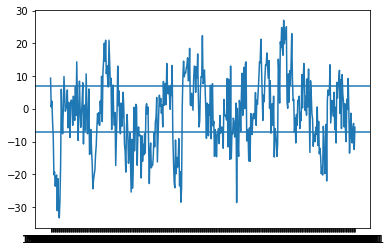

In [159]:
fig, ax = plt.subplots()
ax.plot(df.time, df.soi)
ax.axhline(7)
ax.axhline(-7)

In [177]:
nino = {}
nino['time_start'] = [] # datetime format
nino['time_end'] = [] # datetime format
nino['duration'] = [] # [days]
nina = {}
nina['time_start'] = [] # datetime format
nina['time_end'] = [] # datetime format
nina['duration'] = [] # [days]

enso_thresh = 6

# The nino array is just a time series of months labeled either 'none', 'nino' or 'nina'.
events = xr.full_like(df.soi, 'none', dtype='U4')
enso = xr.full_like(df.soi, 'none', dtype='U4') # Start by labelling all events as neutral ('none').
enso[df.soi < -enso_thresh] = 'nino' # If the SST anomaly is greater than or equal to 0.5°C: label it 'nino'.
enso[df.soi > enso_thresh] = 'nina' # If the SST anomaly is less than or equal to -0.5°C: label it 'nina'.

In [178]:
months = 2
i = 0 # Counter.
ev = 0
while i < len(enso):
    # Check if month 'i' is tagged as 'nino' or 'nina', otherwise just skip to the next month (i + 1).
    if enso[i] != 'none':
        # Find the next day index that is tagged as 'none'. 
        # Note that nino[i:] is the nino array neglecting all the days before 'i' and np.argwhere will tell us 
        # where all the indexes of 'none' are, but we are only interested in the very next 'none' (i.e. [0][0]).

        end = np.argwhere([n != enso[i] for n in enso[i:]])[0][0]

     
        # So, 'end' number of days after day 'i' is when the next non-event occurs 
        # (i.e. the end of the nina or nino event).
        # This means 'end' is the duration of the event. 
        # If the event duration is shorter than the days threshold, rename all these labels as 'none'.
        if end < months:
            enso[i:i + end] = ['none']*(end) 
        
        if enso[i] == 'nino':
            nino['time_start'].append(df.time[i].item())
            nino['time_end'].append(df.time[i + end - 1].item())
            nino['duration'].append(end)

        elif enso[i] == 'nina':
            nina['time_start'].append(df.time[i].item())
            nina['time_end'].append(df.time[i + end - 1].item())
            nina['duration'].append(end)
        # Jump up the counter by all the days we just went through.
        i += end + 1
    else:
        i += 1
        
print('Number of El Nino events: {}'.format(len(nino['time_start'])))
print('Number of La Nina events: {}'.format(len(nina['time_start'])))

# Printing the sum of El Nino and La Nina months.
print('Number of El Nino months: {}'.format((enso == 'nino').sum().item()))
print('Number of La Nina months: {}'.format((enso == 'nina').sum().item()))
print('Number of Neutral months: {}'.format((enso == 'none').sum().item()))

Number of El Nino months: 126
Number of La Nina months: 81
Number of Neutral months: 247


In [188]:
dnino = pd.DataFrame()
dnino['time_start'] = nino['time_start']
dnino['time_end'] = nino['time_end']
dnino['duration'] = nino['duration']

dnina = pd.DataFrame()
dnina['time_start'] = nina['time_start']
dnina['time_end'] = nina['time_end']
dnina['duration'] = nina['duration']

dnina.to_csv(save_path + 'BoM_SOI_nina.csv')
dnino.to_csv(save_path + 'BoM_SOI_nino.csv')

In [194]:
df['nino'] = enso
df.to_dataframe().to_csv(save_path + 'BoM_SOI_ENSO.csv')